<a href="https://colab.research.google.com/github/Natalia9922/Insurance_Recruitment_Project/blob/main/Insurance_N_Pawlowska.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treść zadania:
Jest to publicznie dostępny zbiór dotyczący francuskiego rynku polis komunikacyjnych, przygotowany w taki sposób, żeby sprawiał problemy przy wczytywaniu.
W okresie ubezpieczenia klient może mieć wiele szkód, dlatego nie mówimy o prawdopodobieństwie szkody, a o częstości szkód – jest to liczba szkód podzielona przez liczbę lat ubezpieczenia (ekspozycję). Dla polis krótszych niż rok ekspozycja jest poniżej 1.

1. Przedstawić dane, tak aby słuchacz, który nie widział tych danych wiedział co się w nich
znajduje.
2. Zbudować jak najlepszy model prognozujący częstość szkód, w tym przynajmniej jeden model
klasy GLM oraz przynajmniej jeden model ML/DL.
3. Porównać wyniki zbudowanych modeli i wybrać najlepszy z nich.
4. Wskazać segmenty klientów, dla których predykcje dwóch zbudowanych modeli GLM i
ML/DL najbardziej się różnią.
5. Dla modelu GLM wskazać przykładowych klientów o możliwie najniższym ryzyku oraz o
możliwie najwyższym ryzyku i policzyć dla nich prognozowaną częstość szkód.
6. Dla modelu GLM wskazać zmienną, która najbardziej różnicuje prognozowaną częstość szkód.

Dane otrzymane w ramach rekrutacji firmy ubezpieczeniowej.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance
import xgboost as xgb

# 1. Wczytanie danych
* plik w niektórych wierszach na końcu zawieraja dodatkowe',', zostanie ta kolumna dodatkowa pominięta
przez ustalenie liczby kolumn na podstawie pierwszego wiersza.
* Można zastosować również funkcję w exc do usuwania przecinków na końcu wiersza.

In [ ]:
cols = pd.read_csv('modelowanie_pricing_EH.csv', nrows=1).columns
df = pd.read_csv('modelowanie_pricing_EH.csv', usecols=cols, low_memory=False)

# 2. Analiza Danych

In [ ]:
df

,Unnamed: 0,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,3,10.0,1.0,0.09000,NaN,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678008,678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


In [ ]:
# numer porządkowy zmienimy na typ object
df['IDpol'] = df['IDpol'].astype(object)

In [ ]:
# usuniecie niepotrzebnej kolumny unnamed, która jest powielonym indeksem
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
# sprawdżmy dlaczego Density jest jako object
df.sort_values(by='Density')

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
619430,5061202.0,0.0,0.64,A,4.0,6.0,27.0,80.0,B4,Regular,1.0,R94
619431,5061204.0,0.0,0.07,A,11.0,10.0,27.0,76.0,B1,Diesel,1.0,R94
619432,5061205.0,0.0,0.03,A,11.0,10.0,27.0,76.0,B1,Diesel,1.0,R94
655752,6061203.0,0.0,0.64,A,11.0,15.0,28.0,76.0,B1,Diesel,1.0,R94
655753,6061208.0,0.0,0.10,A,11.0,15.0,28.0,72.0,B1,Diesel,1.0,R94
...,...,...,...,...,...,...,...,...,...,...,...,...
501679,4030749.0,0.0,0.35,D,5.0,1.0,29.0,64.0,B3,Regular,999.0,R93
470712,3235776.0,0.0,0.08,D,6.0,3.0,66.0,61.0,B1,Regular,999.0,R93
381011,3043346.0,0.0,0.92,A,4.0,2.0,60.0,90.0,B12,NaN,Regular,6.0
1435,2967.0,1.0,0.64,B,5.0,0.0,53.0,50.0,B12,NaN,Regular,68.0


In [ ]:
df = df.drop(df[df['Density'] == 'Regular'].index)

* Kolumna Density zawiera niepoprawne wartości 'Regular', ze względu na małą ilość wierszy z tą wartościa zostaną one pominiete w dalszej analizie

In [ ]:
# Sprawdzenie ilości wartości zduplikowanych, 0 świadczy o ich braku
df.duplicated().sum()

0

In [ ]:
#ilość wierszy z brakującymi wartoścami jest <1%, wieć je pominiemy
df.isnull().sum().sum()

11

In [ ]:
# usuwanie wierszy z brakującymi wartościami
df = df.dropna()

In [ ]:
# zmiana typu danych density na liczbę zmiennoprzecinkową
df['Density'] = df['Density'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678000 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678000 non-null  object 
 1   ClaimNb     678000 non-null  float64
 2   Exposure    678000 non-null  float64
 3   Area        678000 non-null  object 
 4   VehPower    678000 non-null  float64
 5   VehAge      678000 non-null  float64
 6   DrivAge     678000 non-null  float64
 7   BonusMalus  678000 non-null  float64
 8   VehBrand    678000 non-null  object 
 9   VehGas      678000 non-null  object 
 10  Density     678000 non-null  float64
 11  Region      678000 non-null  object 
dtypes: float64(7), object(5)
memory usage: 67.2+ MB


In [ ]:
display(df.describe())
display(df.describe(include=[object]))

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678000.000000,678000.000000,678000.000000,678000.000000,678000.000000,678000.000000,678000.000000
mean,0.053242,0.528747,6.454643,7.044301,45.499031,59.761544,1792.447835
std,0.240109,0.364441,2.050914,5.666239,14.137490,15.636699,3958.678381
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


,IDpol,Area,VehBrand,VehGas,Region
count,678000.0,678000,678000,678000,678000
unique,678000.0,6,11,2,22
top,1.0,C,B12,Regular,R24
freq,1.0,191875,166019,345870,160597


* poza kolumną Exposure, wszystkie kolumny numeryczne zawierają wartości odstające. Zostaną one poddane dalszej analizie poniżej.

# 2.1. Wizualizacja danych
* wstępne przetwarzanie danych do wizualicja i modelowania

###  * Kolumny kategoryczne

In [ ]:
cat_columns = ['Area','VehBrand','VehGas','Region']

In [ ]:
df['Area'].value_counts()

C    191875
D    151595
E    137166
A    103953
B     75457
F     17954
Name: Area, dtype: int64

In [ ]:
df['VehBrand'].value_counts()

B12    166019
B1     162735
B2     159858
B3      53394
B5      34751
B6      28548
B4      25179
B10     17707
B11     13585
B13     12177
B14      4047
Name: VehBrand, dtype: int64

In [ ]:
df['VehGas'].value_counts()

Regular    345870
Diesel     332130
Name: VehGas, dtype: int64

In [ ]:
df['Region'].value_counts()

R24    160597
R82     84751
R93     79313
R11     69790
R53     42122
R52     38750
R91     35804
R72     31327
R31     27285
R54     19046
R73     17140
R41     12990
R25     10893
R26     10492
R23      8784
R22      7994
R83      5287
R74      4567
R94      4516
R21      3026
R42      2200
R43      1326
Name: Region, dtype: int64

## * kolumny numeryczne

In [ ]:
num_columns= ['ClaimNb','Exposure','VehPower','VehAge',	'DrivAge','BonusMalus','Density']

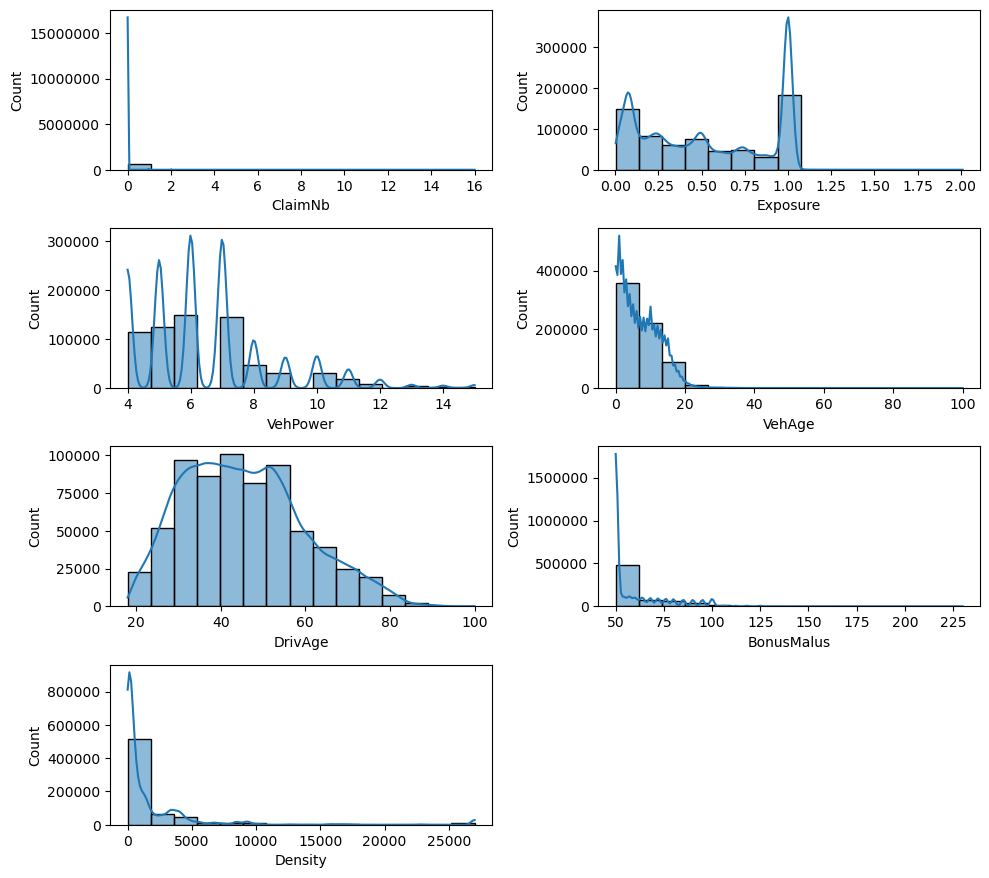

In [ ]:
# sprawdzenie rozkładów danych, wizualizaja danych numerycznych
def plot_histograms(df, columns, bins=15):
    plt.figure(figsize=(10, 15))

    for i, column in enumerate(columns, start=1):
        plt.subplot(len(columns), 2, i)
        sns.histplot(data=df, x=column, bins=bins, kde=True)
        plt.ticklabel_format(style='plain')


    plt.tight_layout()
    plt.show()

plot_histograms(df, num_columns)

* Widoczne są wartości odstające (długie ogony), zostaną one poddane modyfikacji w dalszych krokach.
* Density ze względu na rozkład danych prawoskośny, zostanie poddany przekształceniu logarytmicznemu.

### - ClaimNB

In [ ]:
df['ClaimNb'].value_counts()

0.0     643944
1.0      32174
2.0       1784
3.0         82
4.0          7
11.0         3
5.0          2
6.0          1
8.0          1
16.0         1
9.0          1
Name: ClaimNb, dtype: int64

Zmniejszymy zakres roszczeń do 4, ze względu na pojedyńczą ich ilość powyżej tego zakresu.

In [ ]:
df['ClaimNb'] = df['ClaimNb'].apply(lambda x: 4 if x > 4 else x)

### - Exposure

In [ ]:
df['Exposure'].value_counts()

1.00    168120
0.08     44670
0.07     12969
0.24     12950
0.50     12495
         ...  
2.00         1
1.99         1
1.82         1
1.67         1
1.93         1
Name: Exposure, Length: 187, dtype: int64

In [ ]:
# Zliczmy ile jest wartości powyżej 1
(df['Exposure']>1).sum()

1224

In [ ]:
# Ze względu nie niewielką ilość w stosunku do całego zbioru danych, dane powyżej >1 zmniejszymy zakred do 1, zmieniając dane powyżej 1 na 1
df['Exposure'] = df['Exposure'].apply(lambda x: 1 if x > 1 else x)

### - VehPower

In [ ]:
df['VehPower'].value_counts()

6.0     148974
7.0     145397
5.0     124818
4.0     115346
8.0      46956
10.0     31354
9.0      30084
11.0     18352
12.0      8214
13.0      3229
15.0      2926
14.0      2350
Name: VehPower, dtype: int64

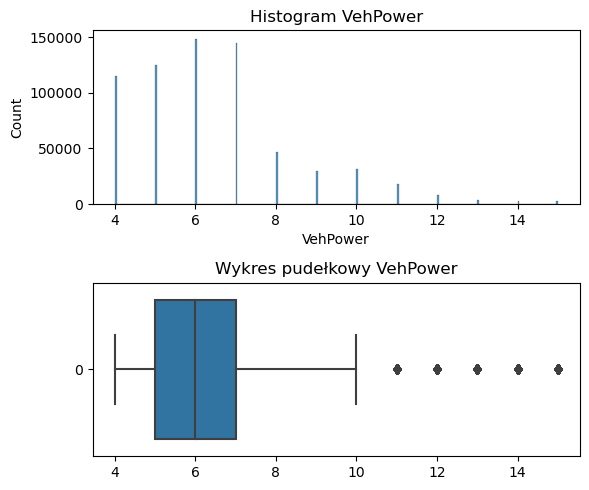

In [ ]:
# Ustaw wielkość figur
plt.figure(figsize=(6, 5))

# Tworzenie pierwszego subplotu (histogram)
plt.subplot(2, 1, 1)
sns.histplot(data=df['VehPower'])
plt.title('Histogram VehPower')

# Tworzenie drugiego subplotu (wykres pudełkowy)
plt.subplot(2, 1, 2)
sns.boxplot(data=df['VehPower'], orient='h')
plt.title('Wykres pudełkowy VehPower')

# Wyświetlanie wykresów
plt.tight_layout()
plt.show()

Warości odstające występują powyżej 10, w związku z czym zmienimy zakres mocy do 10.

In [ ]:
df['VehPower']=df['VehPower'].apply(lambda x: 10 if x > 10 else x)

### - VehAge

In [ ]:
df['VehAge'].value_counts()

1.0     71282
2.0     59123
0.0     57736
3.0     50261
4.0     43492
        ...  
85.0        1
78.0        1
60.0        1
63.0        1
71.0        1
Name: VehAge, Length: 78, dtype: int64

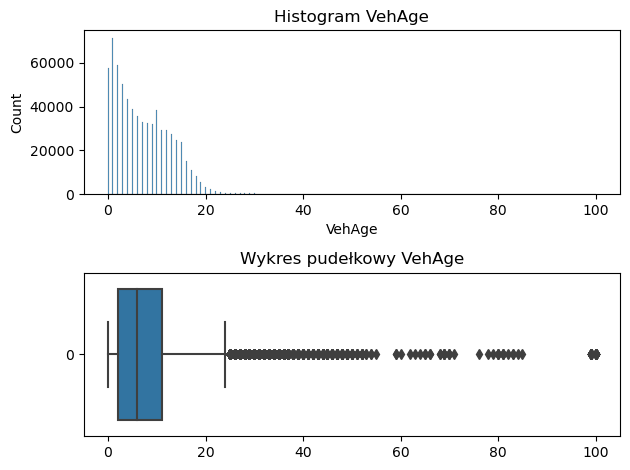

In [ ]:
plt.subplot(2, 1, 1)
sns.histplot(data=df['VehAge'])
plt.title('Histogram VehAge')

plt.subplot(2, 1, 2)
sns.boxplot(data=df['VehAge'], orient='h')
plt.title('Wykres pudełkowy VehAge')

plt.tight_layout()
plt.show()

Auta w wieku powyżej 24 lat występują sporadycznie, zakres zostanie zmieniony do tego punktu.

In [ ]:
(df['VehAge']>24).sum()

3114

In [ ]:
df['VehAge']=df['VehAge'].apply(lambda x: 24 if x > 24 else x)

### - DrivAge

In [ ]:
df['DrivAge'].value_counts()

36.0     17530
38.0     17346
39.0     17320
37.0     17295
52.0     17194
         ...  
95.0        24
96.0        15
97.0        10
98.0         5
100.0        3
Name: DrivAge, Length: 83, dtype: int64

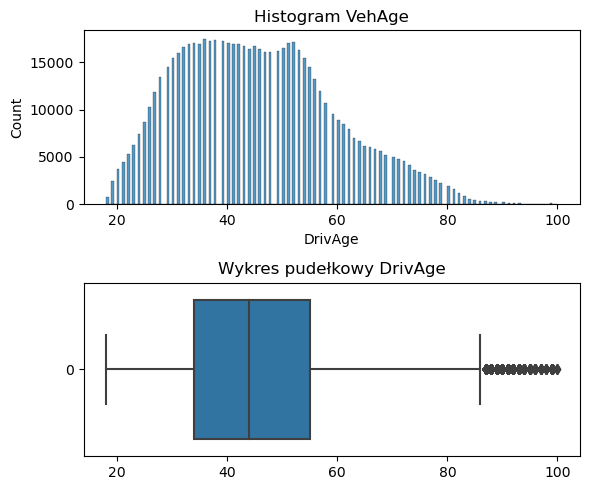

In [ ]:
plt.figure(figsize=(6, 5))

plt.subplot(2, 1, 1)
sns.histplot(data=df['DrivAge'])
plt.title('Histogram VehAge')

plt.subplot(2, 1, 2)
sns.boxplot(data=df['DrivAge'], orient='h')
plt.title('Wykres pudełkowy DrivAge')

plt.tight_layout()
plt.show()

Analogicznie jak wcześniej, zakres zostanie zmieniony do 85 lat

In [ ]:
(df['DrivAge']>85).sum()

1594

In [ ]:
df['DrivAge']=df['DrivAge'].apply(lambda x: 85 if x > 85 else x)

### - BonusMalus

In [ ]:
df['BonusMalus'].value_counts()

50.0     384147
100.0     19530
68.0      18791
72.0      18579
76.0      18226
          ...  
135.0         1
136.0         1
230.0         1
208.0         1
151.0         1
Name: BonusMalus, Length: 115, dtype: int64

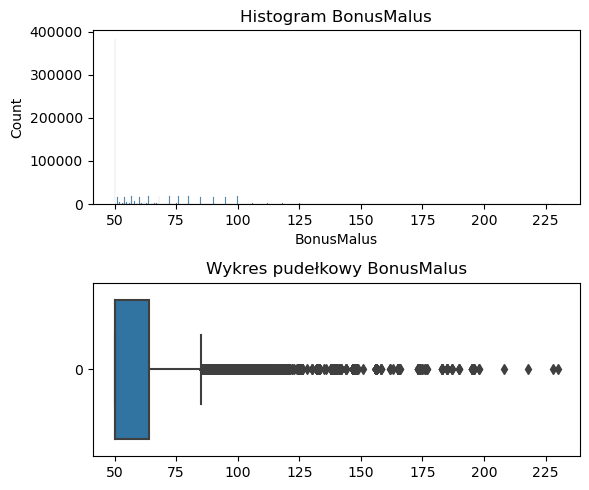

In [ ]:
plt.figure(figsize=(6, 5))

plt.subplot(2, 1, 1)
sns.histplot(data=df['BonusMalus'])
plt.title('Histogram BonusMalus')

plt.subplot(2, 1, 2)
sns.boxplot(data=df['BonusMalus'], orient='h')
plt.title('Wykres pudełkowy BonusMalus')

plt.tight_layout()
plt.show()

BonusMalus posiada sporo wartości odstających, zakres zmniejszymy do 150, gdzie widoczne są pojedyńcze wartości odstające.

In [ ]:
(df['BonusMalus']>150).sum()

209

In [ ]:
df['BonusMalus'] = df['BonusMalus'].apply(lambda x: 150 if x > 150 else x)

### - Density

In [ ]:
df['Density'].value_counts()

27000.0    10515
3317.0      9891
1313.0      7157
9307.0      5986
3744.0      5540
           ...  
1036.0         2
1013.0         2
1126.0         2
869.0          1
1651.0         1
Name: Density, Length: 1607, dtype: int64

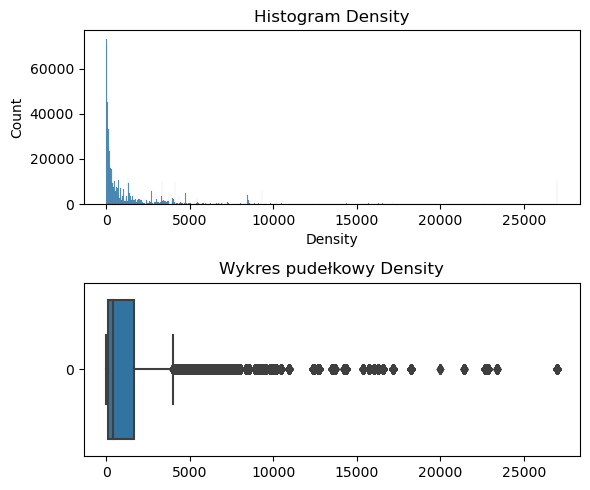

In [ ]:
plt.figure(figsize=(6, 5))

plt.subplot(2, 1, 1)
sns.histplot(data=df['Density'])
plt.title('Histogram Density')

plt.subplot(2, 1, 2)
sns.boxplot(data=df['Density'], orient='h')
plt.title('Wykres pudełkowy Density')

plt.tight_layout()
plt.show()

Zmniejszymy zakres do 20000, zmniejszając zakres wartości odstających i ze wzglęu na rozkład prawoskośny, przeprowadzimy transformacje logarytmiczną.

In [ ]:
df['Density'] = df['Density'].apply(lambda x: 20000 if x > 20000 else x)

In [ ]:
df['Density'] = np.log(df['Density'])

### - utworzenie kolumny zmiennej celu Frequency - częstości szkody

In [ ]:
 df['Frequency'] = df['ClaimNb'] / df['Exposure']

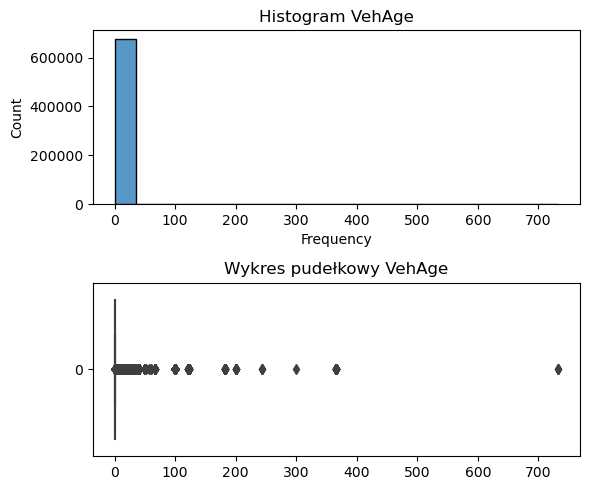

In [ ]:
plt.figure(figsize=(6, 5))

plt.subplot(2, 1, 1)
sns.histplot(data=df['Frequency'])
plt.title('Histogram VehAge')

plt.subplot(2, 1, 2)
sns.boxplot(data=df['Frequency'], orient='h')
plt.title('Wykres pudełkowy VehAge')

plt.tight_layout()
plt.show()

Krótkie czasy trwania polisy z wystąpieniem szkody w tym czasie, stanowczo zakłócają realne wartości częstotliwości szkody w trakcie np. roku, co jest widoczne na wykresie pudełkowym. Zmienimy zakres na bardziej realny do 6.   

In [ ]:
(df['Frequency']>6).sum()

4840

In [ ]:
df['Frequency'] = df['Frequency'].apply(lambda x: 6 if x > 6 else x)

<Axes: xlabel='Frequency', ylabel='Count'>

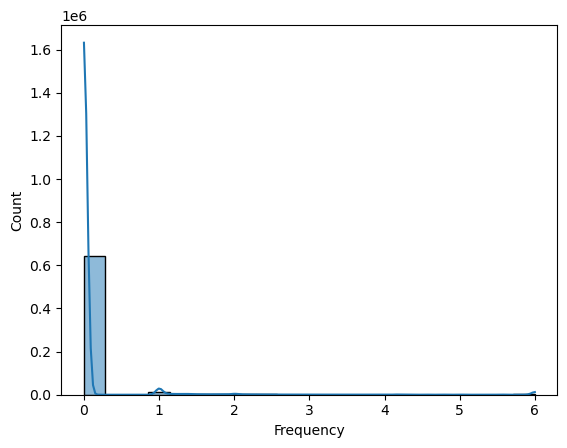

In [ ]:
sns.histplot(data= df['Frequency'], kde=True)

C:\Users\npawl\AppData\Local\Temp\ipykernel_3312\1440197167.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df=df.corr()


<Axes: >

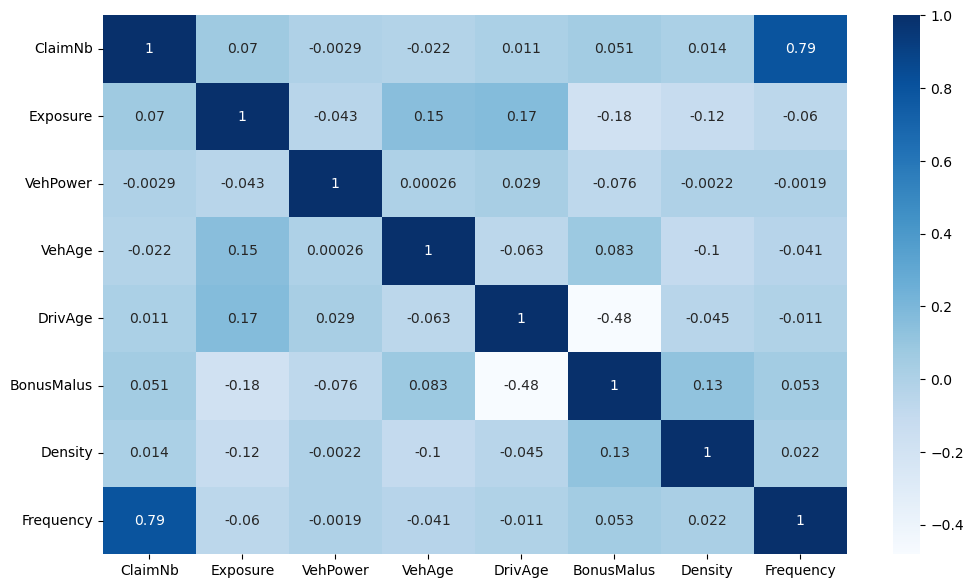

In [ ]:
corr_df=df.corr()
plt.figure(figsize=(12,7))
sns.heatmap(corr_df,annot=True,fmt='.2g',cmap='Blues')

* Modelowanie danych będziemy przeprowadzać w oparciu o rozkład poissona, ze względu na analize częstości szkody w oparciu wystąpień niezależnych doświadczeń w czasie.
* Ze względu na uniknięcie przecieku danych ClaimNB, Exposure nie będa wykorzystywane do uczenia modelu.

## 2.2. Prezentacja danych

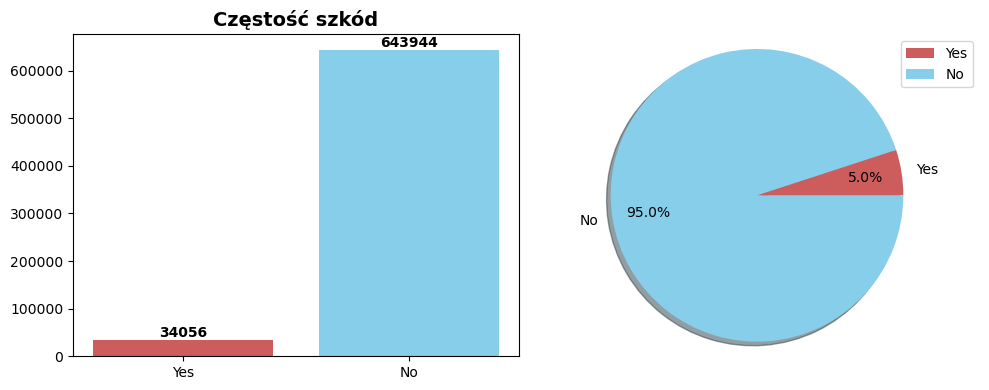

In [ ]:
# Zlicz wystąpienia ClaimNb > 0 i = 0
yes_claim = df[df['ClaimNb'] > 0]['ClaimNb'].count()
no_claim = df[df['ClaimNb'] == 0]['ClaimNb'].count()

labels = ['Yes', 'No']
sizes = [yes_claim, no_claim]

colors = ['indianred', 'skyblue']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Wykres kołowy
ax[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0, shadow=True, pctdistance=0.75)
ax[1].axis('equal')
ax[1].legend(labels, loc="upper right")

# Wykres słupkowy
ax[0].bar(labels, sizes, color=colors)
ax[0].set_title('Częstość szkód', fontsize=14, fontweight='bold')

# Etykiety wartości nad słupkami
for i, v in enumerate(sizes):
    ax[0].text(i, v + 5, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

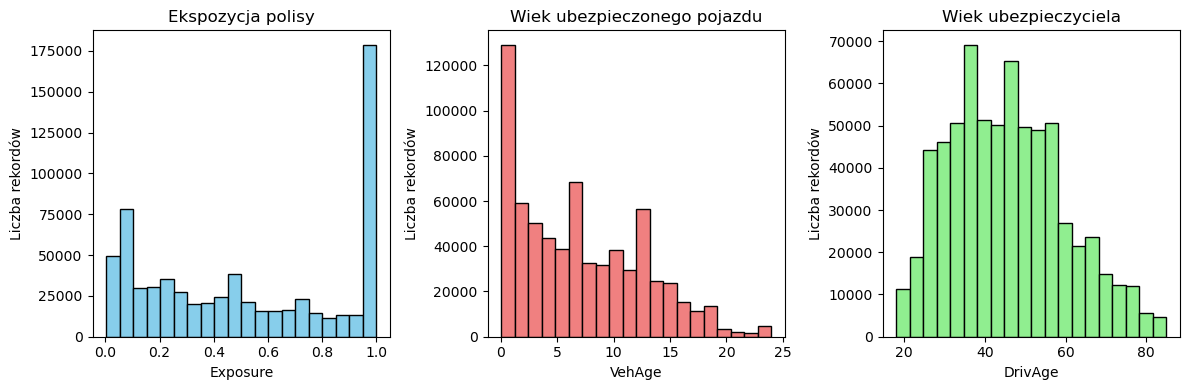

In [ ]:
# Tworzenie histogramów
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.hist(df['Exposure'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Exposure')
plt.ylabel('Liczba rekordów')
plt.title('Ekspozycja polisy')

plt.subplot(132)
plt.hist(df['VehAge'], bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('VehAge')
plt.ylabel('Liczba rekordów')
plt.title('Wiek ubezpieczonego pojazdu')

plt.subplot(133)
plt.hist(df['DrivAge'], bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('DrivAge')
plt.ylabel('Liczba rekordów')
plt.title('Wiek ubezpieczyciela')

plt.tight_layout()
plt.show()

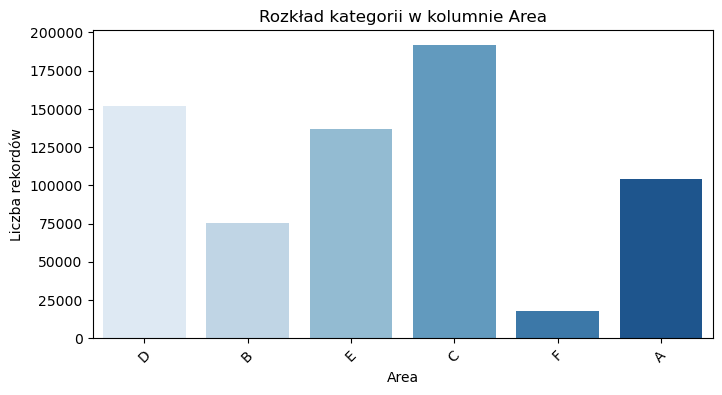

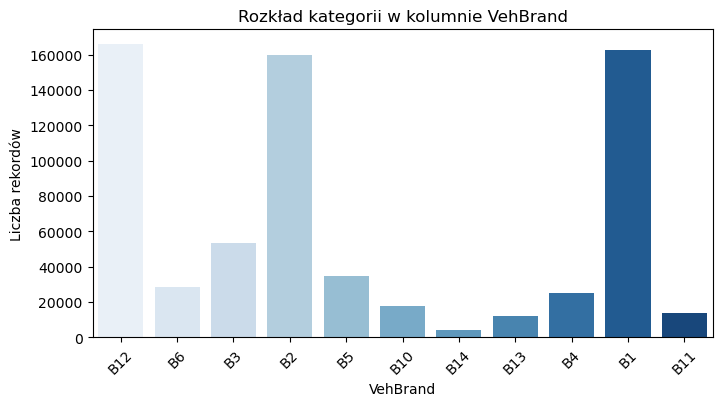

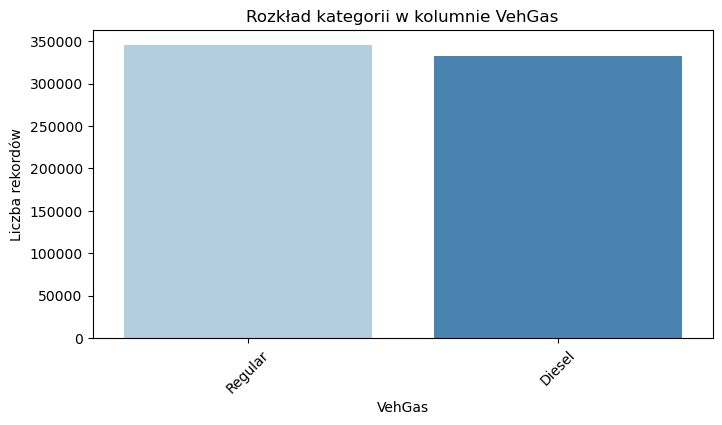

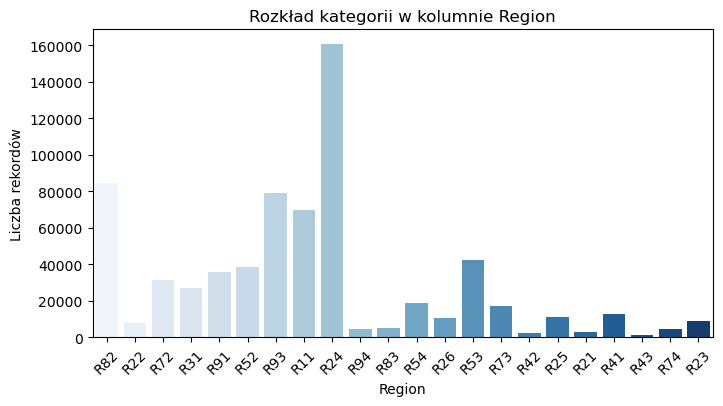

In [ ]:
# Kolumny do wizualizacji
categorical_columns = ['Area', 'VehBrand', 'VehGas', 'Region']

# Tworzenie wykresów słupkowych
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=column, palette='Blues')
    plt.xlabel(column)
    plt.ylabel('Liczba rekordów')
    plt.xticks(rotation=45)
    plt.title(f'Rozkład kategorii w kolumnie {column}')
    plt.show()

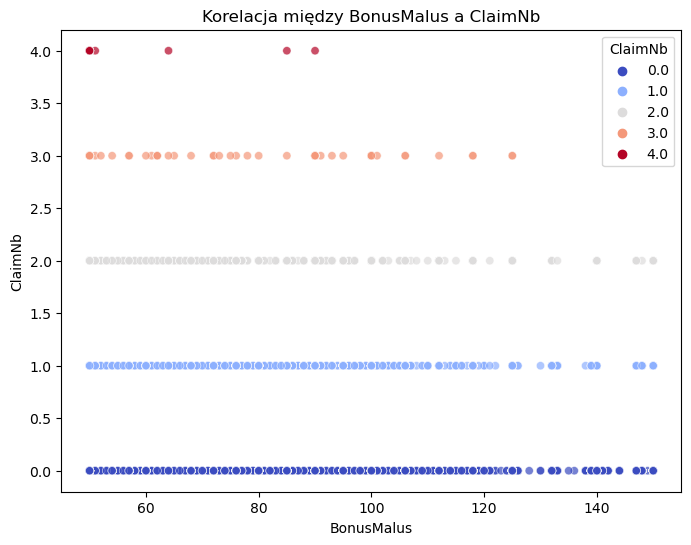

In [ ]:
# Tworzenie wykresu punktowego
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='BonusMalus', y='ClaimNb', hue='ClaimNb', palette='coolwarm', alpha=0.7)
plt.xlabel('BonusMalus')
plt.ylabel('ClaimNb')
plt.title('Korelacja między BonusMalus a ClaimNb')
plt.show()

### Dodatkowe modyfikacje danych do analizy

In [ ]:
# Zamiana liter na liczby w kolumnie 'Area'
df['Area'] = df['Area'].apply(lambda x: ord(x) - ord('A') + 1)

# 3. Podział danych na treningowe i testowe

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
X_train = df_train.drop(['Frequency','ClaimNb','Exposure','IDpol'],axis=1)
y_train = df_train['Frequency']

In [ ]:
X_test = df_test.drop(['Frequency','ClaimNb','Exposure','IDpol'],axis=1)
y_test= df_test['Frequency']

## 3.1. Przygotowanie danych treningowych

In [ ]:
X_train_enc = X_train[['VehBrand', 'VehGas', 'Region']]

In [ ]:
X_train.drop(X_train[['VehBrand', 'VehGas', 'Region']],axis = 1,inplace = True)

In [ ]:
ohe = OneHotEncoder()
X_train_enc = ohe.fit_transform(X_train_enc).toarray()

In [ ]:
X_train_ohc = pd.DataFrame(X_train_enc, columns=ohe.get_feature_names_out(input_features=['VehBrand', 'VehGas', 'Region']))

In [ ]:
X_train_ohc.columns

Index(['VehBrand_B1', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
       'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3',
       'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'VehGas_Diesel',
       'VehGas_Regular', 'Region_R11', 'Region_R21', 'Region_R22',
       'Region_R23', 'Region_R24', 'Region_R25', 'Region_R26', 'Region_R31',
       'Region_R41', 'Region_R42', 'Region_R43', 'Region_R52', 'Region_R53',
       'Region_R54', 'Region_R72', 'Region_R73', 'Region_R74', 'Region_R82',
       'Region_R83', 'Region_R91', 'Region_R93', 'Region_R94'],
      dtype='object')

In [ ]:
X_train_con = pd.concat([X_train, X_train_ohc], axis=1)

In [ ]:
X_train_con

,Area,VehPower,VehAge,DrivAge,BonusMalus,Density,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,3,6.0,14.0,24.0,95.0,5.659482,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,5.0,1.0,43.0,50.0,8.123854,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,6.0,13.0,52.0,50.0,3.970292,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,5.0,12.0,44.0,50.0,7.391415,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3,4.0,0.0,62.0,50.0,5.356586,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542395,3,9.0,12.0,52.0,50.0,5.697093,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
542396,5,6.0,2.0,33.0,68.0,8.037543,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542397,5,9.0,5.0,55.0,50.0,8.227910,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
542398,4,4.0,1.0,43.0,50.0,6.773080,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_con)

## 3.2. Przygotowanie danych testowych

In [ ]:
X_test_enc = X_test[['VehBrand', 'VehGas', 'Region']]
X_test_enc = ohe.transform(X_test_enc).toarray()
X_test_ohc = pd.DataFrame(X_test_enc, columns=ohe.get_feature_names_out(input_features=['VehBrand', 'VehGas', 'Region']))

In [ ]:
X_test.drop(X_test[['VehBrand', 'VehGas', 'Region']],axis = 1,inplace = True)

In [ ]:
X_test_con = pd.concat([X_test, X_test_ohc], axis=1)

In [ ]:
X_test_scaled = scaler.transform(X_test_con)

# 4. Modelowanie

## 4.1. RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(n_estimators=200,
                                  random_state=42,
                                  criterion='poisson',
                                 max_depth = 5)

regressor.fit(X_train_scaled, y_train,
              sample_weight=df_train['Exposure'])

y_pred_RF = regressor.predict(X_test_scaled)

## 4.2. XGBRegressor

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42,tree_method = "hist")

param_grid = {
    'n_estimators': [50,100,200],
    'eta' : [0.01,0.025],
    'subsample' : [0.5,0.9],
    'min_child_weight' : [10,20],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3)

grid_search.fit(X_train_scaled, y_train, sample_weight=df_train['Exposure'])

best_xgb_model = grid_search.best_estimator_

y_pred_xgb = best_xgb_model.predict(X_test_scaled)

In [ ]:
print(grid_search.best_params_)

{'eta': 0.025, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.9}


In [ ]:
# Wyniki dla częsci treningowej

y_train_pred = best_xgb_model.predict(X_train_scaled)

mse = metrics.mean_squared_error(y_train, y_train_pred, sample_weight=df_train['Exposure'].round(2))
mae = metrics.mean_absolute_error(y_train, y_train_pred, sample_weight=df_train['Exposure'].round(2))

print('Constant average frequency rating: ')
print("MSE: ", mse)
print("MAE: ", mae)

mask = y_train_pred > 0
mpd = metrics.mean_poisson_deviance(y_train[mask], y_train_pred[mask], sample_weight=df_train['Exposure'][mask].round(2))
print('Mean Poisson deviance: ', mpd)

Constant average frequency rating: 
MSE:  0.18708358504544287
MAE:  0.17143200766402938
Mean Poisson deviance:  0.5038585702602825


## 4.4. Model GLM - Poisson Regressor

In [ ]:
poisson_glm = PoissonRegressor()

param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'max_iter': [50,100, 150, 200],
    'solver' : ['lbfgs', 'newton-cholesky']
}

grid_search = GridSearchCV(estimator=poisson_glm, param_grid=param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train, sample_weight=df_train['Exposure'])

best_poisson_glm = grid_search.best_estimator_

y_pred_poisson = best_poisson_glm.predict(X_test_scaled)

In [ ]:
print(grid_search.best_params_)

{'alpha': 0.01, 'max_iter': 50, 'solver': 'newton-cholesky'}


In [ ]:
# Wyniki dla częsci treningowej

y_pred_train = best_poisson_glm.predict(X_train_scaled)
mse = metrics.mean_squared_error(y_train, y_pred_train, sample_weight=df_train['Exposure'].round(2))
mae = metrics.mean_absolute_error(y_train, y_pred_train, sample_weight=df_train['Exposure'].round(2))

print('Constant average frequency rating: ')
print("MSE: ", mse)
print("MAE: ", mae)

mpd = metrics.mean_poisson_deviance(y_train, y_pred_train, sample_weight=df_train['Exposure'])
print('mean Poisson deviance: ', mpd)

Constant average frequency rating: 
MSE:  0.19267116300997225
MAE:  0.17340886944150166
mean Poisson deviance:  0.5328213481512568


## 4.4.  Wybranie najlepszego modelu ML

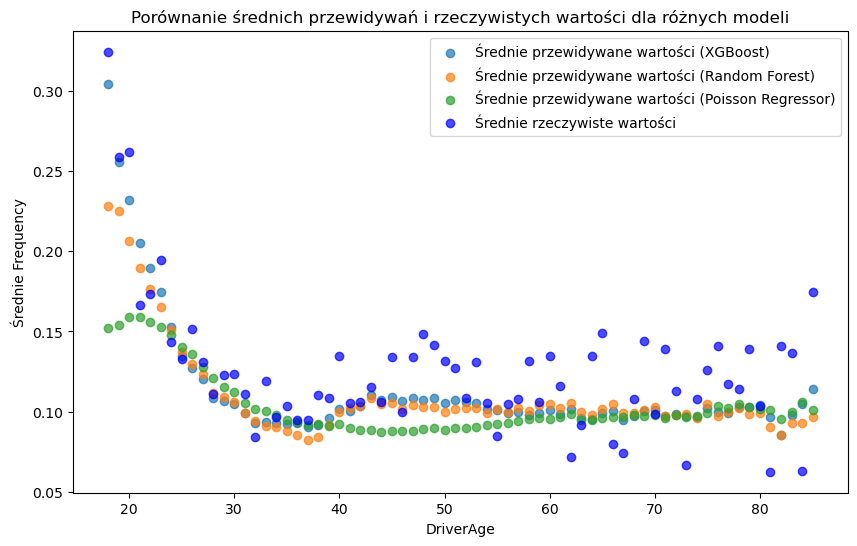

In [ ]:
models = ['XGBoost','Random Forest', 'Poisson Regressor']
y_preds = [y_pred_xgb, y_pred_RF, y_pred_poisson]
x_test = X_test['DrivAge']
y_true = y_test

plt.figure(figsize=(10, 6))

for model, y_pred in zip(models, y_preds):
    # Grupowanie danych według DriverAge i obliczanie średnich wartości
    unique_x_test = np.unique(x_test)
    mean_y_pred = [np.mean(y_pred[x_test == x]) for x in unique_x_test]

    # Utworzenie wykresu
    plt.scatter(unique_x_test, mean_y_pred, label=f"Średnie przewidywane wartości ({model})", alpha=0.7)

# Obliczanie średnich rzeczywistych wartości na podstawie y_test
mean_y_test = [np.mean(y_test[x_test == x]) for x in unique_x_test]

# Dodawanie rzeczywistych wartości do wykresu
plt.scatter(unique_x_test, mean_y_test, label="Średnie rzeczywiste wartości", color="blue", alpha=0.7)

plt.xlabel("DriverAge")
plt.ylabel("Średnie Frequency")
plt.legend()
plt.title("Porównanie średnich przewidywań i rzeczywistych wartości dla różnych modeli")
plt.show()

### - porównanie wyników

In [ ]:
results = {
    'Model': ['Poisson', 'XGBoost', 'Random Forest'],
    'MSE': [],
    'MAE': [],
    'Mean Poisson Deviance': []
}

# Wyniki dla modelu Poisson
mse_poisson = metrics.mean_squared_error(y_test, y_pred_poisson, sample_weight=df_test['Exposure'])
mae_poisson = metrics.mean_absolute_error(y_test, y_pred_poisson, sample_weight=df_test['Exposure'])
mpd_poisson = metrics.mean_poisson_deviance(y_test, y_pred_poisson, sample_weight=df_test['Exposure'])

results['MSE'].append(mse_poisson)
results['MAE'].append(mae_poisson)
results['Mean Poisson Deviance'].append(mpd_poisson)

# Wyniki dla modelu XGBoost
mse_xgboost = metrics.mean_squared_error(y_test, y_pred_xgb, sample_weight=df_test['Exposure'])
mae_xgboost = metrics.mean_absolute_error(y_test, y_pred_xgb, sample_weight=df_test['Exposure'])
mpd_xgboost = metrics.mean_poisson_deviance(y_test, y_pred_xgb, sample_weight=df_test['Exposure'])

results['MSE'].append(mse_xgboost)
results['MAE'].append(mae_xgboost)
results['Mean Poisson Deviance'].append(mpd_xgboost)

# Wyniki dla modelu Random Forest
mse_rf = metrics.mean_squared_error(y_test, y_pred_RF, sample_weight=df_test['Exposure'])
mae_rf = metrics.mean_absolute_error(y_test, y_pred_RF, sample_weight=df_test['Exposure'])
mpd_rf = metrics.mean_poisson_deviance(y_test, y_pred_RF, sample_weight=df_test['Exposure'])

results['MSE'].append(mse_rf)
results['MAE'].append(mae_rf)
results['Mean Poisson Deviance'].append(mpd_rf)

results_df = pd.DataFrame(results)

results_df

,Model,MSE,MAE,Mean Poisson Deviance
0,Poisson,0.186417,0.171834,0.524398
1,XGBoost,0.182634,0.170253,0.503520
2,Random Forest,0.183835,0.169140,0.509839


* Model XGBoost ma najniższe wartości MSE,MAE,mean poisson deviance co sugeruje najlepsze wyniki predykcji w porównaniu do pozostałych modeli.

## 5. Wskazanie segmentów klientów, dla których predykcje dwóch zbudowanych modeli GLM i ML/DL najbardziej się różnią.

In [ ]:
# Tworzenie ramki danych
df_predictions = pd.DataFrame({
    'Index': X_test.index,
    'y_test': y_test,
    'y_pred_xgb': y_pred_xgb,
    'y_pred_poisson': y_pred_poisson,
})

# Obliczanie różnicy między wynikami y_pred_xgb i y_pred_poisson
df_predictions['Diff_xgb_poisson'] = abs(df_predictions['y_pred_xgb'] - df_predictions['y_pred_poisson'])

df_predictions

,Index,y_test,y_pred_xgb,y_pred_poisson,Diff_xgb_poisson
0,0,0.000000,0.073106,0.114897,0.041791
1,1,0.000000,0.093800,0.112691,0.018890
2,2,0.000000,0.123499,0.085969,0.037530
3,3,0.000000,0.064493,0.083526,0.019033
4,4,0.000000,0.083650,0.096544,0.012894
...,...,...,...,...,...
135595,135595,0.000000,0.085582,0.151632,0.066050
135596,135596,0.000000,0.078262,0.073309,0.004952
135597,135597,0.000000,0.132860,0.089244,0.043616
135598,135598,0.000000,0.050202,0.060283,0.010082


In [ ]:
# Sortowanie danych według kolumny różnicy (Diff_xgb_poisson) w kolejności malejącej
df_sorted = df_predictions.sort_values(by='Diff_xgb_poisson', ascending=False)

# Wyświetlenie 20 rekordów z największą różnicą
top_segments = df_sorted.head(20)

# Wyświetlenie wybranych segmentów
print(top_segments)

         Index    y_test  y_pred_xgb  y_pred_poisson  Diff_xgb_poisson
37761    37761  0.000000    1.017015        0.289795          0.727219
87186    87186  1.408451    0.758105        0.064795          0.693309
88205    88205  1.538462    0.759143        0.078862          0.680281
54304    54304  0.000000    0.756604        0.079812          0.676792
63523    63523  1.020408    0.760938        0.088984          0.671954
125695  125695  0.000000    0.755243        0.087347          0.667897
6617      6617  0.000000    0.749117        0.083533          0.665584
28424    28424  0.000000    0.739819        0.076436          0.663383
45335    45335  6.000000    0.753800        0.090487          0.663313
117668  117668  0.000000    0.739819        0.076897          0.662922
79299    79299  0.000000    0.750544        0.087825          0.662719
35619    35619  4.444444    0.750544        0.087873          0.662671
48877    48877  0.000000    0.745700        0.084539          0.661161
57968 

In [ ]:
# Pobieranie indeksów wierszy z top_segments
selected_indices = top_segments.index

# Wyświetlenie X_train dla wybranych wierszy
df_test_selected = df_test.loc[selected_indices]
df_test_selected

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
37761,1014324.0,0.0,0.43,4,5.0,0.0,31.0,100.0,B12,Regular,7.350516,R82,0.000000
87186,696.0,1.0,0.71,1,5.0,0.0,33.0,50.0,B12,Regular,3.850148,R41,1.408451
88205,2030.0,1.0,0.65,3,9.0,0.0,41.0,50.0,B12,Regular,4.897840,R41,1.538462
54304,2027920.0,0.0,0.02,3,5.0,0.0,32.0,50.0,B12,Regular,5.318120,R91,0.000000
63523,3142.0,1.0,0.98,2,9.0,0.0,47.0,50.0,B12,Regular,3.988984,R91,1.020408
125695,1014281.0,0.0,0.08,1,9.0,0.0,50.0,50.0,B12,Regular,3.091042,R72,0.000000
6617,2216217.0,0.0,0.22,1,9.0,0.0,50.0,50.0,B12,Regular,1.791759,R91,0.000000
28424,5107046.0,0.0,0.04,1,5.0,0.0,37.0,50.0,B12,Regular,3.871201,R72,0.000000
45335,5206.0,1.0,0.14,3,9.0,0.0,39.0,50.0,B12,Regular,5.579730,R91,6.000000
117668,1002045.0,0.0,0.22,1,5.0,0.0,38.0,50.0,B12,Regular,3.871201,R72,0.000000


Predykcje różnią się najbardziej dla segmentów klientów z BonusMalus o wartosci 50, VehBrand B12, Vehgas Regular o VehPower 9 i 5 z nowym pojazdem (VehAge = 0).

## 6. Dla modelu GLM wskazać przykładowych klientów o możliwie najniższym ryzyku oraz o możliwie najwyższym ryzyku i policzyć dla nich prognozowaną częstość szkód.

In [ ]:
# Wyciągnięcie informacji o klientach o najniższycm ryzyku
df_test.nsmallest(5, 'Frequency')

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
0,3250378.0,0.0,0.08,5,4.0,12.0,32.0,76.0,B1,Regular,8.040125,R82,0.0
1,55182.0,0.0,0.43,1,6.0,2.0,29.0,76.0,B3,Diesel,3.258097,R52,0.0
2,3095324.0,0.0,0.25,1,5.0,7.0,53.0,57.0,B5,Diesel,3.401197,R24,0.0
3,4165599.0,0.0,0.11,3,5.0,17.0,24.0,76.0,B3,Diesel,5.686975,R24,0.0
4,2285535.0,0.0,0.08,3,7.0,10.0,34.0,72.0,B13,Regular,5.717028,R91,0.0


In [ ]:
y_pred_poisson_min = best_poisson_glm.predict(X_test_scaled[:5])

In [ ]:
# Kolejno otrzymane prognozy czętości szkód
y_pred_poisson_min

array([0.11489711, 0.11269056, 0.08596885, 0.08352551, 0.09654376])

In [ ]:
# Wyciągnięcie danych o najwyższym ryzku
df_test.nlargest(5, 'Frequency')

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency
212,1016221.0,1.0,0.12,5,7.0,5.0,27.0,80.0,B6,Regular,9.128588,R11,6.0
337,10604.0,1.0,0.04,2,6.0,2.0,59.0,50.0,B12,Diesel,4.499810,R72,6.0
1069,3240637.0,1.0,0.16,5,4.0,8.0,47.0,50.0,B2,Diesel,8.815222,R11,6.0
1092,5107621.0,1.0,0.10,5,4.0,0.0,30.0,112.0,B12,Diesel,8.218248,R26,6.0
1143,39016.0,1.0,0.08,4,6.0,9.0,56.0,50.0,B1,Regular,6.434547,R82,6.0


In [ ]:
# Wybór indeksów o najwyższych wartościach 'Frequency'
selected_indices = df_test.nlargest(5, 'Frequency').index.tolist()

# Wybór odpowiednich wierszy z X_test_scaled
X_selected = X_test_scaled[selected_indices]

# Predykcja dla wybranych wierszy
y_pred_poisson_max = best_poisson_glm.predict(X_selected)

In [ ]:
y_pred_poisson_max

array([0.14288425, 0.08549484, 0.07193364, 0.32646935, 0.08164719])

* jak widać model nie radzi sobie przy wyższych wynikach.

# 7. Dla modelu GLM wskazać zmienną, która najbardziej różnicuje prognozowaną częstość szkód.

In [ ]:
# Przygotowanie df z wspólczynników regresji
coef = pd.DataFrame({'Variable': X_train_con.columns, 'Coefficient': best_poisson_glm.coef_})

# Wybieranie zmiennej o największym wpływie
most_inf_variable = coef.loc[coef['Coefficient'].abs().idxmax()]

print("Najbardziej wpływowa zmienna:")
print(most_inf_variable)

Najbardziej wpływowa zmienna:
Variable       BonusMalus
Coefficient      0.330555
Name: 4, dtype: object
